In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.stattools import acf  # Import the acf function
from statsmodels.tsa.stattools import pacf  # Import the pacf function

from statsmodels.nonparametric.smoothers_lowess import lowess

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.interpolate import interp1d

from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression

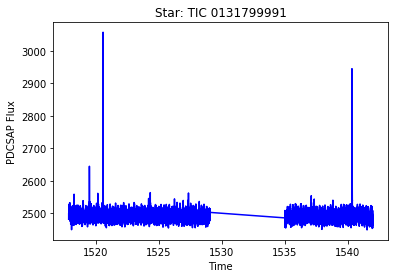

In [2]:
# Load data for star 
star1 = pd.read_csv('0131799991.csv')

# Raw flux vs time for star 1
plt.plot(star1['time'], star1['pdcsap_flux'], label="Star 1", color="blue")
plt.title("Star: TIC 0131799991")
plt.xlabel("Time")
plt.ylabel("PDCSAP Flux")
plt.savefig("star1_ts.png", dpi=300)

plt.show()

In [3]:
star1.head()

,time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,...,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
0,1517.350128,NaN,NaN,0.003094,208722,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1517.352906,NaN,NaN,0.003094,208724,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1517.354295,NaN,NaN,0.003094,208725,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1517.357073,NaN,NaN,0.003095,208727,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1517.358462,NaN,NaN,0.003095,208728,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
star1.shape

(13372, 24)

In [5]:
# Step 1: Calculate time_diff and identify the time gap
star1['time_diff'] = star1['time'].diff()
largest_diff_index = star1['time_diff'].idxmax()
largest_diff_start = star1.iloc[largest_diff_index - 1]['time']
largest_diff_end = star1.iloc[largest_diff_index]['time']
median_interval = star1['time_diff'].median()

# Step 2: Split data into part1 and part3
part1 = star1[star1['time'] <= largest_diff_start].copy()
part3 = star1[star1['time'] > largest_diff_end].copy()

# Remove NaN values from part1 for STL decomposition
part1 = part1.dropna(subset=['pdcsap_flux'])

In [6]:
# Print the timeframe for which values are missing 

# Start
print(largest_diff_start)

# End 
print(largest_diff_end)

1529.0681348448547
1535.0013982910418


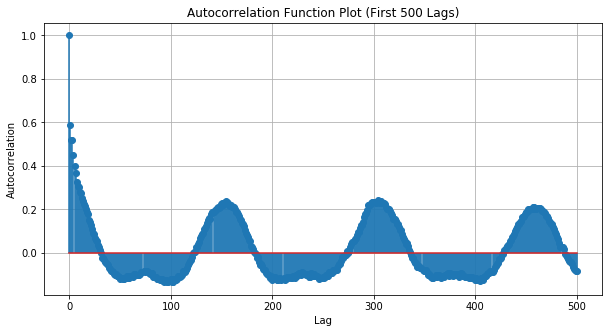

In [7]:
# Compute autocorrelation values for the first 500 lags

acf_values_500 = acf(part1['pdcsap_flux'], nlags=500, fft=True)

conf_bound = 1.96 / np.sqrt(len(part1))

# Plot autocorrelation for the first 500 lags
plt.figure(figsize=(10, 5))
plt.stem(range(len(acf_values_500)), acf_values_500, use_line_collection=True)
#plt.axhline(y=conf_bound, color='blue', linestyle='dashed', label="95% Conf. Interval")
#plt.axhline(y=-conf_bound, color='blue', linestyle='dashed')
plt.title('Autocorrelation Function Plot (First 500 Lags)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
#plt.legend()
plt.grid()
plt.savefig("star1_acf.png", dpi=300)
plt.show()

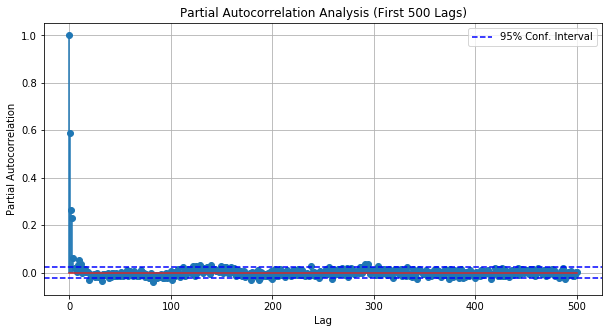

In [8]:
# compute pacf for first 500 lags 

# Compute partial autocorrelation values for the first 500 lags
pacf_values_500 = pacf(part1['pdcsap_flux'].dropna(), nlags=500)

conf_bound = 1.96 / np.sqrt(len(part1))

# Plot partial autocorrelation for the first 500 lags
plt.figure(figsize=(10, 5))
plt.stem(range(len(pacf_values_500)), pacf_values_500, use_line_collection=True)
plt.axhline(y=conf_bound, color='blue', linestyle='dashed', label="95% Conf. Interval")
plt.axhline(y=-conf_bound, color='blue', linestyle='dashed')
plt.title('Partial Autocorrelation Analysis (First 500 Lags)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid()
plt.legend()
plt.show()

In [9]:
# Step 3: Model trend and seasonality of part1 using STL decomposition
stl = STL(part1['pdcsap_flux'], period=150)  # 150 chosen based on acf
result = stl.fit()
part1['trend'] = result.trend
part1['seasonal'] = result.seasonal

In [10]:
# Step 1: Generate new time steps at median intervals
part2_times = np.arange(largest_diff_start + median_interval, largest_diff_end, median_interval)

# Step 2: Create part2 DataFrame to cover the missing times 
part2 = pd.DataFrame({'time': part2_times})

In [11]:
# Find the offset to shift part2 to the correct time range
offset = part1.index.max() + 1  # Start part2 after the last index of part1

# Reindex part2 so that it follows part1
part2.index = np.arange(offset, offset + len(part2))

print("Adjusted part2 index range:", part2.index.min(), "-", part2.index.max())

Adjusted part2 index range: 8345 - 12615


In [12]:
# Extract known x-values and corresponding trend from part1
known_x = part1.index
known_trend = part1['trend'].values

# Fit a linear model to extrapolate the trend
linear_model = np.polyfit(known_x, known_trend, 1)  # Linear regression
predict_trend = np.poly1d(linear_model)  # Create function for prediction

# Predict trend for part2
part2['trend'] = predict_trend(part2.index)

In [13]:
# Extract the last full seasonal cycle from part1
seasonality_period = 150  # Same as STL period
last_seasonal_values = part1['seasonal'].values[-seasonality_period:]

# Extend seasonality for part2 by repeating the pattern
seasonality_predictions = np.tile(last_seasonal_values, len(part2) // seasonality_period + 1)[:len(part2)]

# Assign to part2
part2['seasonal'] = seasonality_predictions

In [14]:
# Compute the imputed response for part2
part2['pdcsap_flux'] = part2['trend'] + part2['seasonal']

In [15]:
# Adjust part3 index to continue from part2
part3.index = np.arange(part2.index.max() + 1, part2.index.max() + 1 + len(part3))

print("Final index ranges:")
print(f"part1: {part1.index.min()} - {part1.index.max()}")
print(f"part2: {part2.index.min()} - {part2.index.max()}")
print(f"part3: {part3.index.min()} - {part3.index.max()}")

Final index ranges:
part1: 338 - 8344
part2: 8345 - 12615
part3: 12616 - 17641


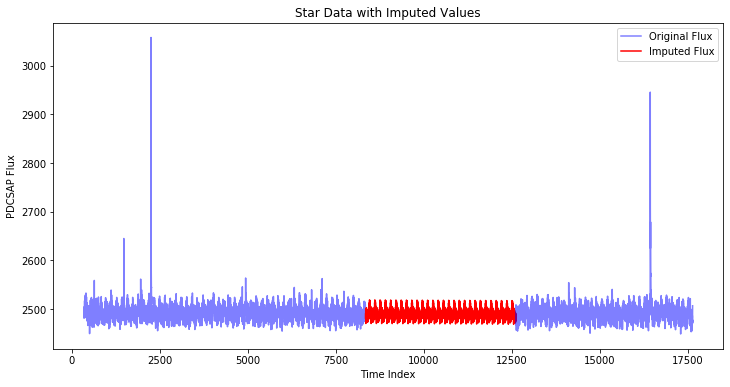

In [16]:
plt.figure(figsize=(12, 6))

# Plot part1 (original data)
plt.plot(part1.index, part1['pdcsap_flux'], label="Original Flux", color='blue', alpha=0.5)

# Plot imputed part2 (predicted response)
plt.plot(part2.index, part2['pdcsap_flux'], label="Imputed Flux", color='red')

# Plot part3 (original data)
plt.plot(part3.index, part3['pdcsap_flux'], color='blue', alpha=0.5)

# Formatting
plt.legend()
plt.xlabel("Time Index")
plt.ylabel("PDCSAP Flux")
plt.title("Star Data with Imputed Values")
plt.savefig("star1_imputed.png", dpi=300)
plt.show()

In [17]:
# Combine all parts while keeping the correct index
full_df1 = pd.concat([part1[['pdcsap_flux']], part2[['pdcsap_flux']], part3[['pdcsap_flux']]])

# Sort by index to maintain order
full_df1 = full_df1.sort_index()

print(full_df1.head())  # Preview the first few rows
print(full_df1.tail())  # Preview the last few rows

     pdcsap_flux
338    2482.1746
339    2499.9043
340    2498.1790
341    2490.4194
342    2495.0884
       pdcsap_flux
17637    2478.6045
17638    2471.6458
17639    2480.8284
17640    2489.7463
17641    2507.0757


In [18]:
# Make copy of the data and work on copy to avoid errors 
star1_data = full_df1.copy()
star1_data = star1_data.reset_index()

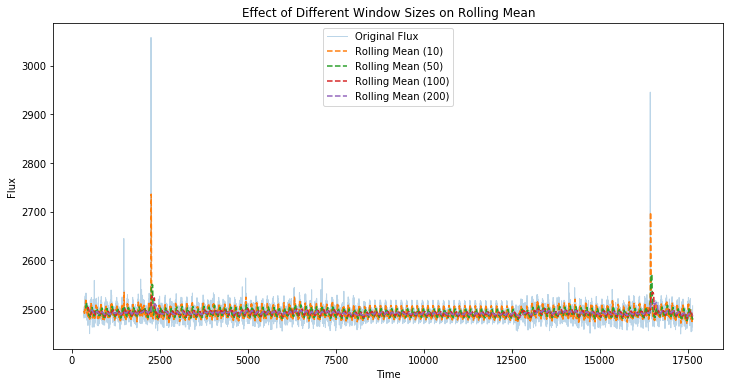

In [19]:
# Investigating rolling mean window 
for ws in [10,50, 100, 200]:
    star1_data[f'flux_roll_mean_{ws}'] = star1_data['pdcsap_flux'].rolling(window=ws).mean()

plt.figure(figsize=(12, 6))
plt.plot(star1_data['index'], star1_data['pdcsap_flux'], label="Original Flux", alpha=0.3, linewidth=1)
plt.plot(star1_data['index'], star1_data['flux_roll_mean_10'], label="Rolling Mean (10)", linestyle="--")
plt.plot(star1_data['index'], star1_data['flux_roll_mean_50'], label="Rolling Mean (50)", linestyle="--")
plt.plot(star1_data['index'], star1_data['flux_roll_mean_100'], label="Rolling Mean (100)", linestyle="--")
plt.plot(star1_data['index'], star1_data['flux_roll_mean_200'], label="Rolling Mean (200)", linestyle="--")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Effect of Different Window Sizes on Rolling Mean")
plt.show()

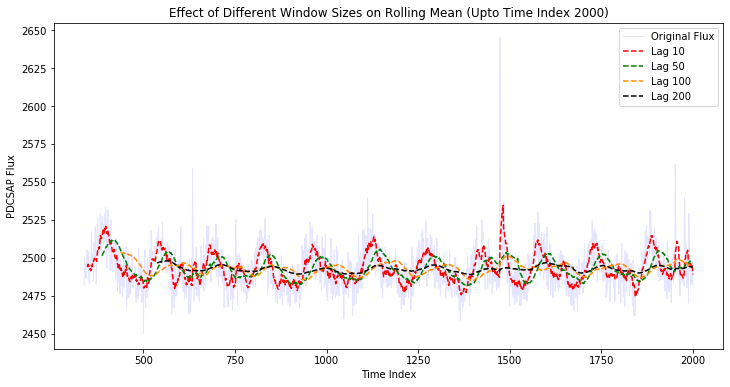

In [20]:
# Plot upto t=2000 for better visualization 

# Define the time range to plot (up to time = 2000)
time_limit = 2000

# Filter the data up to the specified time limit
filtered_data = star1_data[star1_data['index'] <= time_limit]

plt.figure(figsize=(12, 6))

# Plot the original flux values
plt.plot(filtered_data['index'], filtered_data['pdcsap_flux'], label="Original Flux", color='blue', alpha=0.1, linewidth=1)

# Plot the first few lags
plt.plot(filtered_data['index'], filtered_data['flux_roll_mean_10'], label="Lag 10", linestyle='dashed', color='red')
plt.plot(filtered_data['index'], filtered_data['flux_roll_mean_50'], label="Lag 50", linestyle='dashed', color='green')
plt.plot(filtered_data['index'], filtered_data['flux_roll_mean_100'], label="Lag 100", linestyle='dashed', color='darkorange')
plt.plot(filtered_data['index'], filtered_data['flux_roll_mean_200'], label="Lag 200", linestyle='dashed', color='black')

# Formatting
plt.legend()
plt.xlabel("Time Index")
plt.ylabel("PDCSAP Flux")
plt.title("Effect of Different Window Sizes on Rolling Mean (Upto Time Index 2000)")
plt.savefig("star1_rollmean.png", dpi=300)
plt.show()

In [21]:
# Extract additional features from brightness data using chosen rolling window 

def preprocess_data(data, window_size=100):
    
    """
    Extracts flux-related features from stellar brightness flux data.

    Parameters:
    ----------
    data : pandas.DataFrame  
        Input dataframe containing a 'pdcsap_flux' column representing flux values over time.
    window_size : int, optional (default=100)  
        Window size for computing rolling mean and standard deviation.

    Returns:
    -------
    pandas.DataFrame  
        DataFrame with added columns:
        - 'flux_diff': change in flux between consecutive time points  
        - 'flux_ratio': ratio of current flux to previous flux  
        - 'flux_roll_mean': rolling average of flux over the given window  
        - 'flux_roll_std': rolling standard deviation of flux over the given window
    """
    
    # Compute flux differences and ratios
    data['flux_diff'] = data['pdcsap_flux'].diff()
    data['flux_ratio'] = data['pdcsap_flux'] / data['pdcsap_flux'].shift(1)

    # Rolling statistics
    data['flux_roll_mean'] = data['pdcsap_flux'].rolling(window=window_size, min_periods=1).mean()
    data['flux_roll_std'] = data['pdcsap_flux'].rolling(window=window_size, min_periods=1).std()

    return data

In [22]:
# downloading final processed data 

data_star1 = preprocess_data(star1_data)
data_star1= data_star1.iloc[1:].reset_index(drop=True) # drop 1st row with nan 
data_star1.head()

data_star1.to_csv('data_star1.csv', index=False)